### IMPORTANT!
Albumentations automatically installs `opencv-python-headless`. To make both augmentations and SelectiveSearch work, you need to uninstall every `opencv` version and install `opencv-contrib-python-headless`.
https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

In [1]:
# !pip uninstall opencv-python opencv-python-headless

In [2]:
 #!pip install opencv-contrib-python-headless

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ExifTags

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from matplotlib.patches import Polygon, Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (6,6)

# Own imports 
from config import * 
from utils import *
from data_loader import TacoDataset

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(4);

In [4]:
img_size = 256 # 1024 # AM: changed because it takes too long for SelectiveSearch to run

train_transform = A.Compose([
    A.Resize(img_size, img_size),
    #A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(10, 10, 10, p=0.3),
    A.GaussNoise(p=0.5),
    #A.Normalize(), # If you want to visualize - comment this line 
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_area = 50,
                            min_visibility=0.3, # min visibility of the original area in case of a crop
                           )
    
)

test_transform = A.Compose([
    A.Resize(img_size, img_size, cv2.INTER_CUBIC),
    #A.Normalize(),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc',
                            label_fields=['labels'],
                            min_area = 50,
                            min_visibility=0.3
                           )
)

In [5]:
trainset = TacoDataset( 'train', transforms=train_transform, test_size=0.2) # test_transform for no augment
valset   = TacoDataset('val', transforms=test_transform, test_size=0.2)
testset  = TacoDataset('test', transforms=test_transform, test_size=0.2)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8,collate_fn= lambda x: x)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,collate_fn= lambda x: x)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8,collate_fn= lambda x: x)# persistent_workers=True, pin_memory=True)

In [6]:
def selective_search(img):
    """
    Takes image as an input (np.array not Tensor!)
    Returns np.array (number of bboxes x 4)
    Bboxes in format x, y, w, h (see demo notebook for example)
    """
    # create selective search segmentation object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img) 
    # Choose between fast or accurate selective Search method: fast but low recall V.S. high recall but slow 
    ss.switchToSelectiveSearchFast()
    # AM: Quality takes a looong time, maybe better to try with fast for now and see the results, if bad then change to quality
    # ss.switchToSelectiveSearchQuality() 
    # run selective search
    rects = ss.process()
    print('Total Number of Region Proposals: {}'.format(len(rects))) # TODO: comment out after making the whole trainset work
    return rects

In [7]:
train_proposals = []
for i, (img, _, _) in enumerate(tqdm(trainset)):
    proposals = selective_search(img.permute([1,2,0]).numpy())
    train_proposals.append(proposals)

  0%|          | 0/900 [00:00<?, ?it/s]

Total Number of Region Proposals: 632
Total Number of Region Proposals: 164
Total Number of Region Proposals: 780
Total Number of Region Proposals: 719
Total Number of Region Proposals: 547
Total Number of Region Proposals: 970
Total Number of Region Proposals: 271
Total Number of Region Proposals: 372
Total Number of Region Proposals: 220
Total Number of Region Proposals: 247
Total Number of Region Proposals: 802
Total Number of Region Proposals: 442
Total Number of Region Proposals: 365
Total Number of Region Proposals: 307
Total Number of Region Proposals: 589
Total Number of Region Proposals: 773
Total Number of Region Proposals: 476
Total Number of Region Proposals: 487
Total Number of Region Proposals: 325
Total Number of Region Proposals: 465
Total Number of Region Proposals: 397
Total Number of Region Proposals: 393
Total Number of Region Proposals: 873
Total Number of Region Proposals: 623
Total Number of Region Proposals: 404
Total Number of Region Proposals: 657
Total Number

In [8]:
len(train_proposals)

900

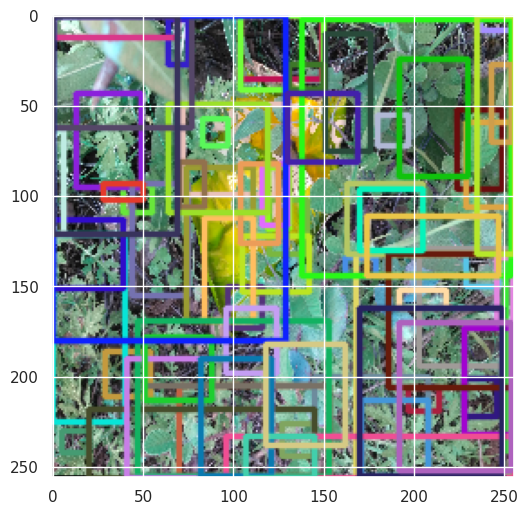

In [9]:
# (for last working img from trainset)

# number of region proposals to show
numShowRects = 70

# create a copy of original image
imOut = img.permute([1,2,0]).numpy().copy()

# itereate over all the region proposals
for i, rect in enumerate(proposals):
    # draw rectangle for region proposal till numShowRects
    if (i < numShowRects):
        x, y, w, h = rect
        color = list(np.random.random(size=3) * 256)
        cv2.rectangle(imOut, (x, y), (x+w, y+h), color, 2, cv2.LINE_AA)
    else:
        break

plt.imshow(imOut[...,::-1])